# SAE 2.01 Partie Graphes

Participants :
 - Esnault Gabin   
 - Pubert Elise  
 - Da-Rocha Gatien  
 - Leborgne Néo  
 
## Table des matières
1. [Introduction](#Introduction)
2. [Code](#Code)
    1. [Importation des librairies](#Importation-des-librairies)
    2. [Lecture des fichiers CSV](#Lecture-des-fichiers-CSV)
    3. [Creation du graphe](#Creation-du-graphe)
        1. [Ajout des sommets](#Ajout-des-sommets)
        2. [Ajout des arcs](#Ajout-des-arcs)
    4. [Visualisation](#Visualisation)
        1. [Coloriage par degre des sommets](#Coloriage-par-degre-des-sommets)
        2. [Coloriage par exentricite des sommets](#Coloriage-par-exentricite-des-sommets)
        3. [Coloriage par distances entre sommets](#Coloriage-par-distances-entre-sommets)
        4. [Coloriage par nombre de passages moyens](#Coloriage-par-nombre-de-passages-moyens)
        



## Introduction
Ce notebook vise à visualiser les données relatives aux pistes cyclables fournies par la municipalité de nantes.

## Code


### Importation des librairies
Veillez à avoir installé les librairies suivantes :
 - pandas
 - numpy
 - matplotlib
 - geopy
 - networkx
 - ast
 - seaborn

In [3]:
# importation des packages
import numpy as np
import pandas as pd
import seaborn as sns
import ast as ast
from geopy.distance import geodesic
import networkx as nx
from math import sqrt

# importation des modules
import scipy.stats as sps

import matplotlib.pyplot as plt
%matplotlib inline
#magic
import warnings
warnings.filterwarnings('ignore')

### Lecture des fichiers CSV
Veuillez également à déposer les fichiers CSV (`data_geolocalisationCompteur_uniques.csv`, et `data_comptageVelo.csv`) dans le même dossier que ce notebook.

In [4]:
# importation du fichier csv comme un panda dataframe
capteurs=pd.read_csv("data_geolocalisationCompteur_uniques.csv", sep=';')

# adaptation du format des données de géolocalisation
ast.literal_eval(capteurs['Geolocalisation'][0])

# création de la colone Latitude
capteurs['Latitude']=capteurs['Geolocalisation'].apply(lambda x : ast.literal_eval(x)[0])

# création de la colone Longitude
capteurs['Longitude']=capteurs['Geolocalisation'].apply(lambda x : ast.literal_eval(x)[1])

# Création de dataframe/dictionary plus lisibles
capteurs_lite= capteurs[['Numeros','Latitude','Longitude']].copy()


# Création d'un dictionaire, structure proche des graphes networkx
capteurs_dict = {x : [capteurs_lite.iloc[x,0],capteurs_lite.iloc[x,1], capteurs_lite.iloc[x,2]] for x in range(len(capteurs_lite['Numeros']))}
capteurs_lite.tail()

,Numeros,Latitude,Longitude
23,"907,889",47.148193,-1.693909
24,"681,680",47.218907,-1.537043
25,"996,997",47.232667,-1.548799
26,1032,47.314798,-1.543337
27,1031,47.140529,-1.713694


In [5]:
# importation du fichier csv comme un panda dataframe
comptages=pd.read_csv("data_comptageVelo.csv", sep=';')

comptage_lite = comptages[['boucle_num','total']].copy()
comptage_lite

,boucle_num,total
0,667,2559
1,673,0
2,725,485
3,744,683
4,948,315
...,...,...
73463,680,0
73464,746,102
73465,847,452
73466,945,87


### Creation du graphe
#### Ajout des sommets
Un sommet est créé pour chaque compteur de vélo. Les coordonnées géographiques sont récupérées dans le fichier `data_geolocalisationCompteur_uniques.csv`.

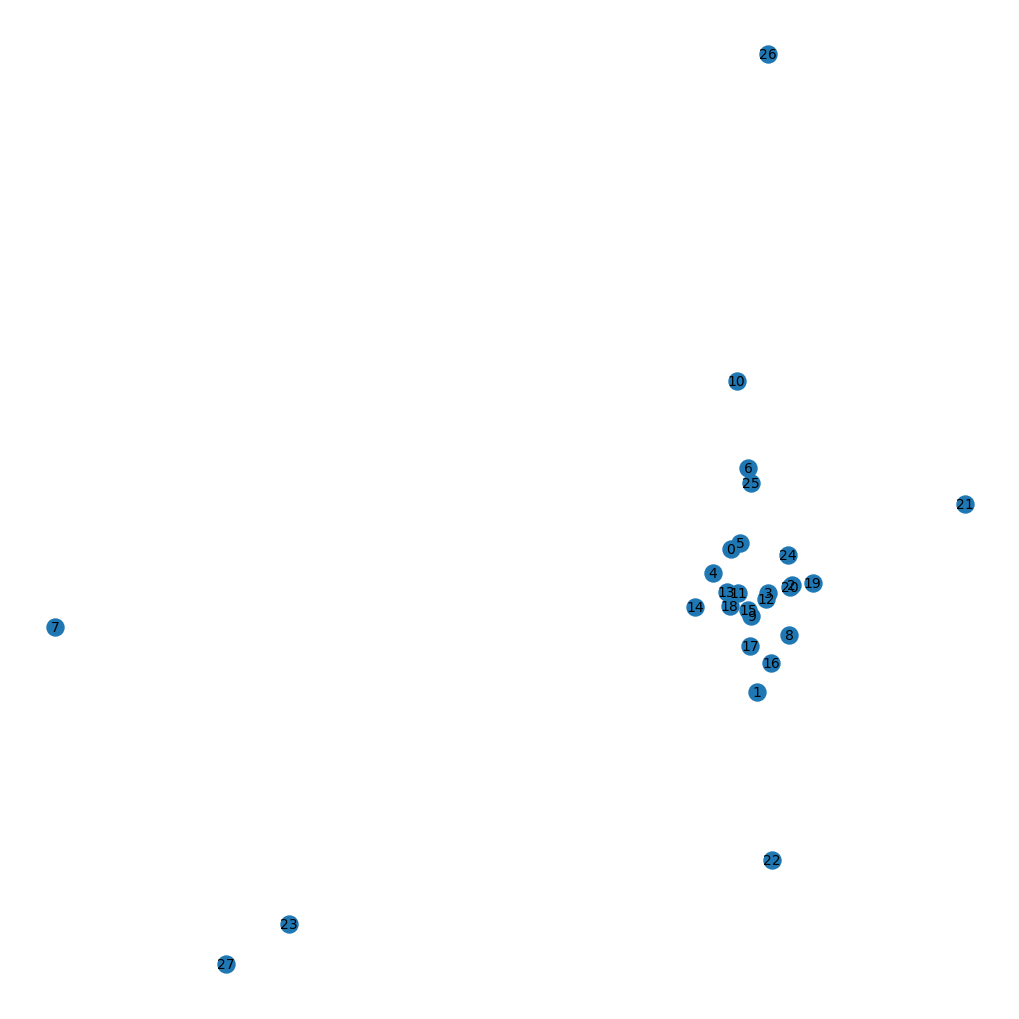

In [6]:
G = nx.Graph(name = "Vélo_Nantes")
for index, row in capteurs_lite.iterrows():
    G.add_node(index,numeros=[int(x) for x in row[0].split(',')],lat=row[1],long=row[2])

# Proposition de dictionaire de position pour le tracé en networkx

def pos_graph(v):
    x=float(v[1])
    y=float(v[2])
    
    #on peut adapter les coordonnées
    x=(x-47.20)*1000
    y=(y+1.543)*1000
    
    return np.array([y,x])

capteurs_pos = dict((k, pos_graph(v)) for k, v in capteurs_dict.items())

plt.figure(figsize=(10,10))             
nx.draw(G,pos=capteurs_pos,node_size=150, alpha=1, font_size=10, with_labels=True)
plt.show()

#### Ajout des arcs
N'ayant pas de données sur les pistes disponibles entre chaque compteur, nous ne pouvons que deviner les pistes cyclables.

//TODO: décrire la modélisation

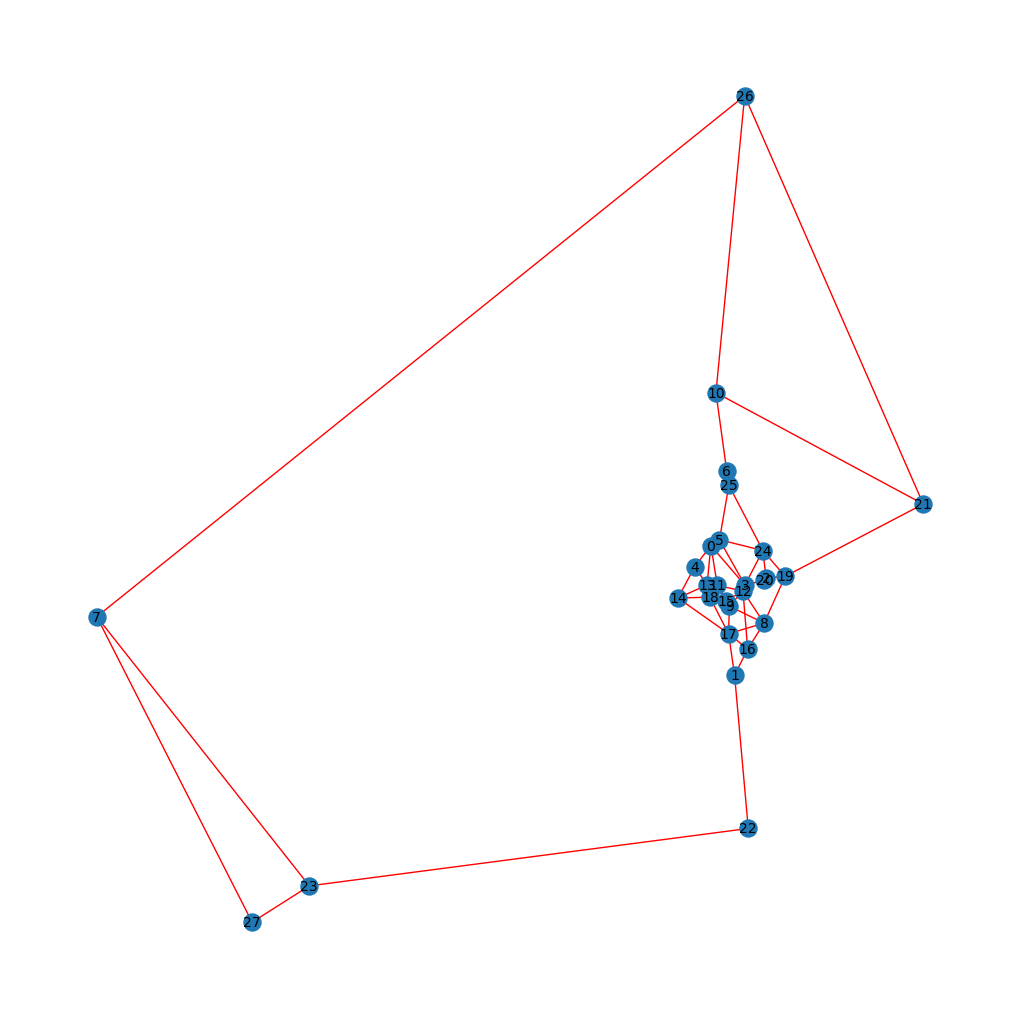

In [7]:
G = nx.Graph(name = "Vélo_Nantes")
for index, row in capteurs_lite.iterrows():
    G.add_node(index,numeros=[int(x) for x in row[0].split(',')],lat=row[1],long=row[2])

G.nodes[0]

## table des distance
n=len(G.nodes)
dist_table_geo=np.zeros((n,n))



for s in G.nodes:
    for t in G.nodes:
        dist=geodesic((G.nodes[s]['lat'],G.nodes[s]['long']),(G.nodes[t]['lat'],G.nodes[t]['long'])).km
        dist_table_geo[s,t]=dist
    
#print(dist_table_geo)


#On ajoute l'arête [s,t] si il n'existe pas de sommet u tq d(s,u)+d(u,t) < 1.15 d(s,t)
for s in G.nodes:
    for t in G.nodes:
        if dist_table_geo[s,t]>.05 :
            add=True
            for u in G.nodes:
                #Que fait-on ici ? Quel est l'impact du paramètre ?
                if dist_table_geo[s,u]+dist_table_geo[u,t] < 1.15* dist_table_geo[s,t] and dist_table_geo[s,u]>.05 and dist_table_geo[t,u]>.05:
                    add=False
            if add : 
                G.add_edge(s,t,distance=dist_table_geo[s,t])

            
plt.figure(figsize=(10,10))
nx.draw(G,pos=capteurs_pos,node_size=150, width=1, alpha=1, edge_color='r', font_size=10, with_labels=True)
             
plt.show()

### Visualisation

#### Coloriage par degre des sommets

Liste de degrés : [5, 3, 3, 5, 3, 4, 2, 3, 5, 4, 3, 5, 6, 5, 4, 4, 4, 6, 5, 4, 2, 3, 2, 3, 5, 3, 3, 2]


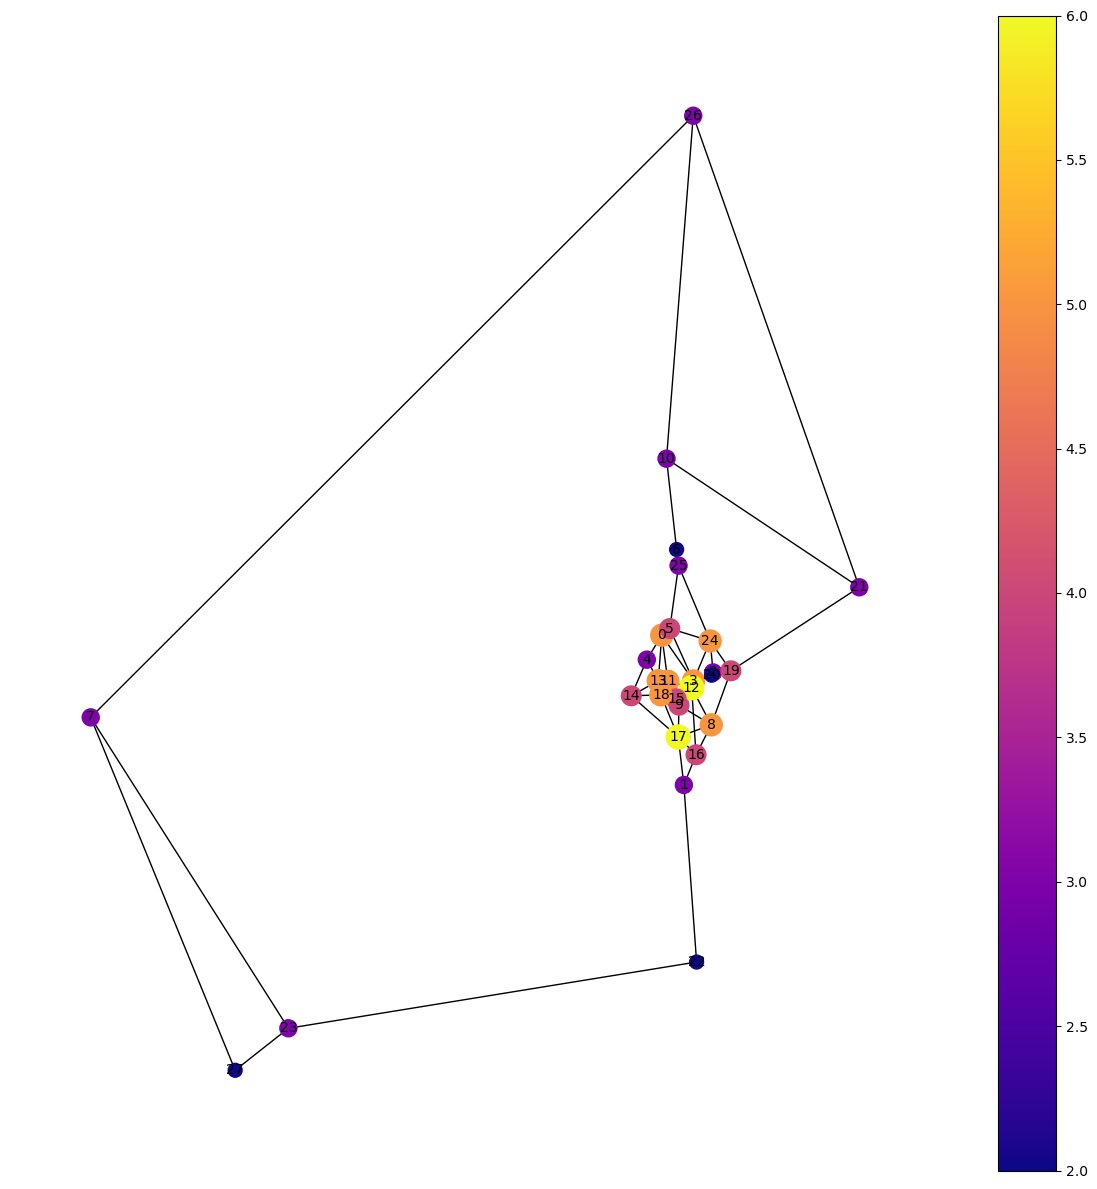

In [8]:
def coloration_par_degre(G):
    colors = [0 for n in range(len(G.nodes))]
    for a,b in G.edges :
        colors[a] += 1
        colors[b] += 1
    return colors

colors = coloration_par_degre(G)
print(f"Liste de degrés : {colors}")
plt.figure(figsize=(15,15))             

vmin=min(colors)
vmax=max(colors)
cmap = plt.cm.plasma
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)
nx.draw(G,pos=capteurs_pos,node_size=[couleur * 50 for couleur in colors], width=1, alpha=1, node_color=colors, font_size=10, with_labels=True,cmap=cmap)

plt.show()

#### Coloriage par exentricite des sommets

In [9]:
def excentricite(graphe, n):
    # Initialisation des excentricités à 0
    excentricites = [0] * n
    
    # Parcours en largeur à partir de chaque noeud pour calculer l'excentricité
    for s in range(n):
        visited = [False] * n
        distance = [0] * n
        visited[s] = True
        queue = [s]
        
        while queue:
            u = queue.pop(0)
            for v in graphe[u]:
                if not visited[v]:
                    visited[v] = True
                    distance[v] = distance[u] + 1
                    queue.append(v)
        
        # Mise à jour de l'excentricité pour chaque nœud
        for i in range(n):
            if distance[i] > excentricites[s]:
                excentricites[s] = distance[i]
    
    return excentricites

Liste des excentricité [7, 6, 5, 6, 6, 6, 6, 6, 5, 5, 5, 6, 5, 6, 5, 6, 5, 5, 5, 4, 6, 5, 6, 6, 5, 6, 6, 7]


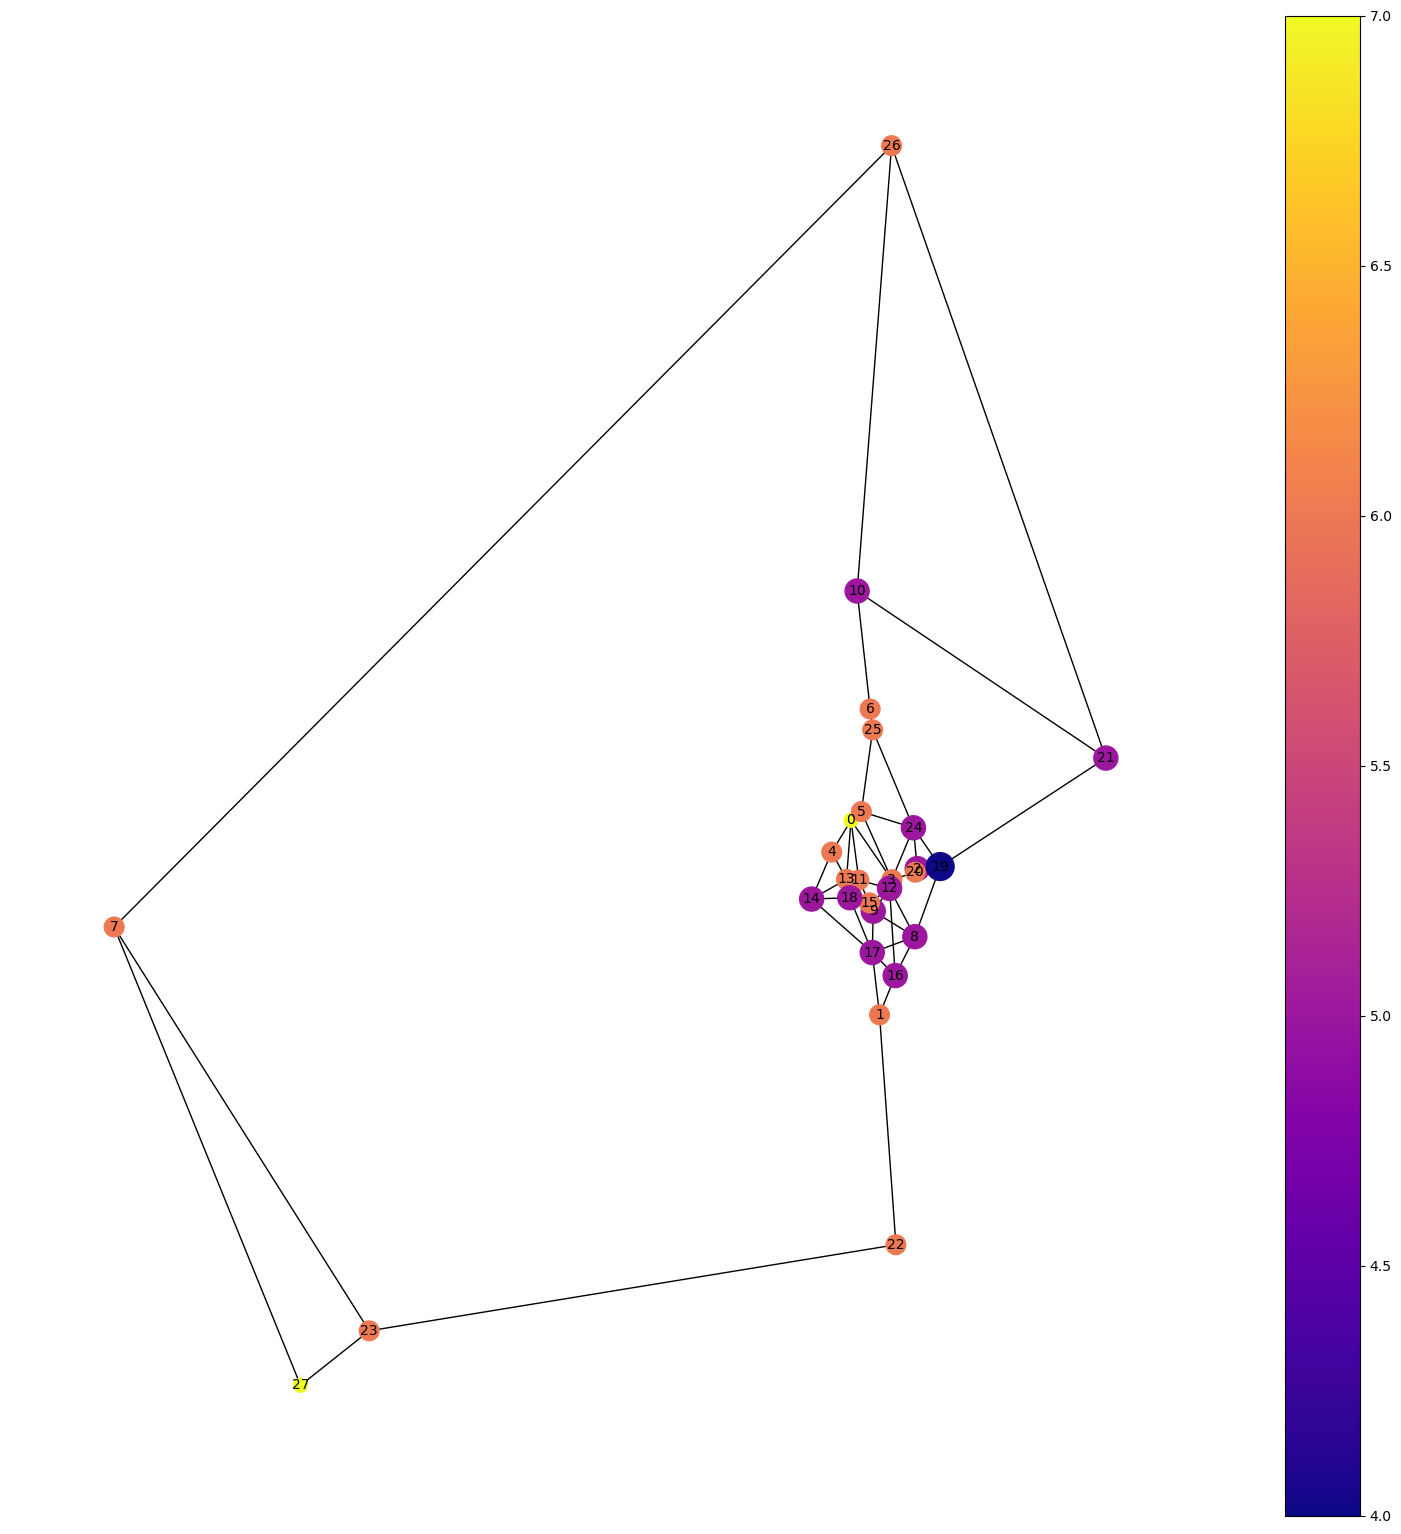

In [10]:
# Calcul des excentricités
colors = excentricite(G,len(G.nodes))
print(f"Liste des excentricité {colors}")

# Affichage
cmap = plt.cm.plasma
plt.figure(figsize=(15,15))             
nx.draw(G,pos=capteurs_pos,node_size=[(couleur-8) * -100 for couleur in colors], width=1, alpha=1, node_color=colors, font_size=10, with_labels=True,cmap=cmap)

vmin=min(colors)
vmax=max(colors)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)

plt.show()

#### Coloriage par distances entre sommets
Plus les axes sont épais, plus leur existence est essentielle

Liste des longueurs : [14, 7, 3, 9, 8, 7, 9, 33, 7, 1, 6, 13, 1, 7, 10, 6, 9, 15, 12, 17, 3, 93, 250, 84, 13, 10, 8, 12, 12, 6, 2, 6, 75, 63, 9, 4, 4, 4, 6, 12, 10, 3, 19, 11, 6, 7, 10, 50, 9, 106, 152, 21, 18]


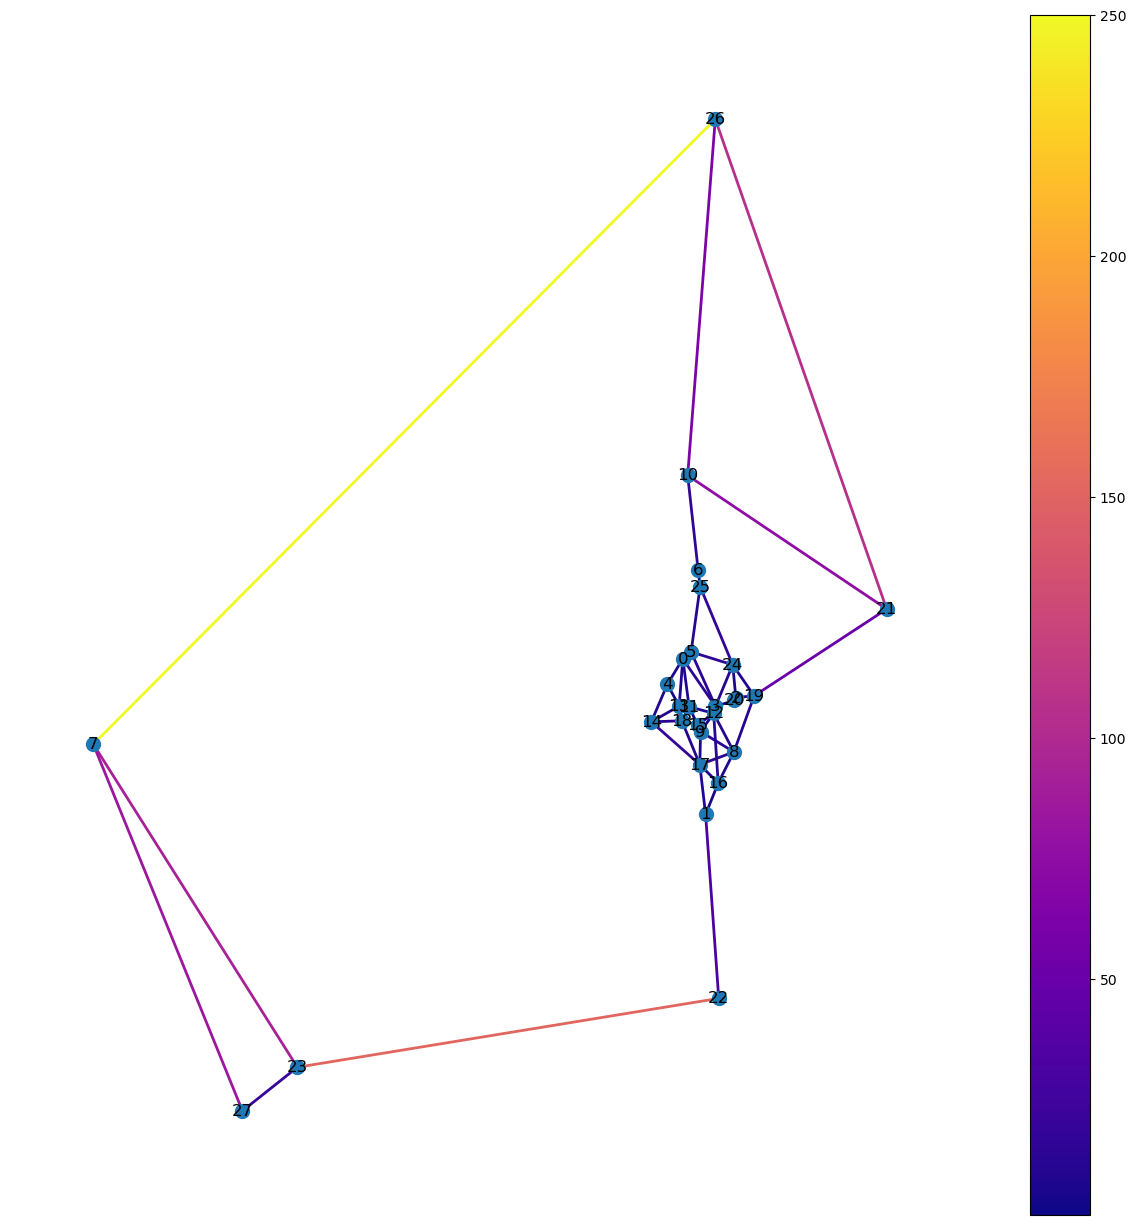

In [11]:
def coloration_par_distance(G):
    colors = [0]*len(G.edges)
    for index,(a,b) in enumerate(G.edges) :
        
        # Calcul Euclidien de la distance
        colors[index] = round(sqrt((capteurs_dict[a][1] - capteurs_dict[b][1])**2 + (capteurs_dict[a][2] - capteurs_dict[b][2])**2)*1000)
    return colors

colors = coloration_par_distance(G)
print(f"Liste des longueurs : {colors}")


# Affichage
cmap = plt.cm.plasma
plt.figure(figsize=(12,12))             

nx.draw(G, pos=capteurs_pos, with_labels=True, node_size=100, edge_color=colors, width=2,edge_cmap=cmap,)
vmin=min(colors)
vmax=max(colors)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)
plt.show()


#### Coloriage par nombre de passages moyens

In [12]:
lst_capteurs = []
for numBoucles in capteurs_lite["Numeros"]:
    lst_capteurs.append(numBoucles)
# print(lst_capteurs)

lst_moyenne = [0]*len(G.nodes)

for boucleID, total in zip(comptage_lite["boucle_num"],comptage_lite["total"]) :
    for index, capteurs in enumerate(lst_capteurs) :
        if str(boucleID) in capteurs :
            numero = index
            
            break
    lst_moyenne[numero] += int(total)
lst_moyenne = [(lst_moyenne[k]//len(comptage_lite['boucle_num']))*10 for k in range(len(lst_moyenne))]
print(lst_moyenne)


[1080, 120, 20, 210, 90, 230, 160, 0, 170, 550, 60, 470, 320, 280, 200, 20, 370, 150, 170, 180, 120, 0, 80, 0, 150, 200, 0, 0]


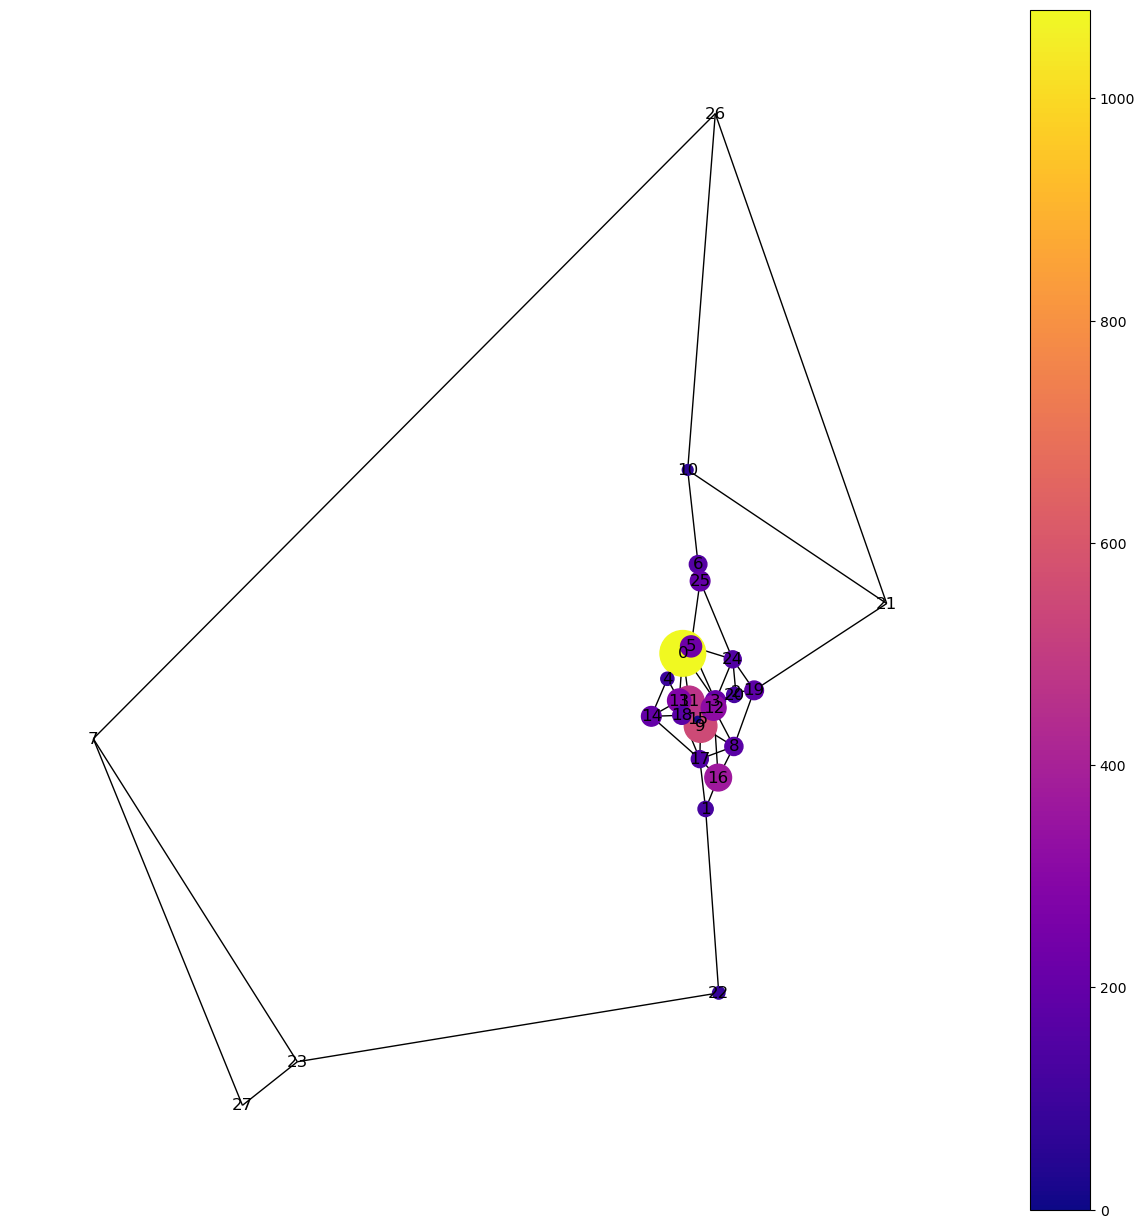

In [13]:
# Affichage
cmap = plt.cm.plasma
plt.figure(figsize=(12,12))             

nx.draw(G, pos=capteurs_pos, with_labels=True, node_size=lst_moyenne, node_color=lst_moyenne,cmap=cmap,)
vmin=min(lst_moyenne)
vmax=max(lst_moyenne)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)
plt.show()


#### Etude du plus court chemin

In [21]:
def graph_to_weight_matrix(graph):
    # Obtenir la liste des noeuds dans le graphe
    nodes = list(graph.nodes())

    # Initialiser la matrice d'adjacence
    adjacency_matrix = np.full((len(nodes), len(nodes)), np.inf)

    # Remplir la matrice d'adjacence
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if i != j:
                if graph.has_edge(nodes[i], nodes[j]):
                    # Calculer de la distance
                    adjacency_matrix[i][j] = round(sqrt((capteurs_dict[i][1] - capteurs_dict[j][1])**2 + (capteurs_dict[i][2] - capteurs_dict[j][2])**2)*1000)
            else :
                adjacency_matrix[i][j] = 0
    
    return adjacency_matrix

In [19]:
def dijkstra(matrix, start, end):
    # Initialiser les distances et les noeuds visités
    distances = [np.inf] * len(matrix)
    visited = [False] * len(matrix)

    # La distance de départ est de 0
    distances[start] = 0

    # Initialiser le chemin le plus court
    shortest_path = [None] * len(matrix)

    # Parcourir tous les noeuds
    for i in range(len(matrix)):
        # Trouver le noeud avec la plus petite distance
        min_distance = np.inf
        for j in range(len(matrix)):
            if not visited[j] and distances[j] < min_distance:
                min_distance = distances[j]
                min_node = j

        # Marquer le noeud comme visité
        visited[min_node] = True

        # Mettre à jour les distances des noeuds adjacents
        for j in range(len(matrix)):
            if matrix[min_node][j] > 0 and not visited[j]:
                new_distance = distances[min_node] + matrix[min_node][j]
                if new_distance < distances[j]:
                    distances[j] = new_distance
                    shortest_path[j] = min_node

    # Construire le chemin le plus court
    path = []
    node = end
    while node is not None:
        path.append(node)
        node = shortest_path[node]
    path.reverse()

    # Retourner la distance la plus courte et le chemin le plus court entre le noeud de départ et le noeud d'arrivée
    return distances[end], path

In [22]:
# Definition des bornes
DEPART = 4
ARRIVEE = 27

# Calcul de la plus courte distance
Adj = graph_to_weight_matrix(G)
print(f"Matrice d'adjacence : {Adj}")

distance,ppc = dijkstra(Adj,DEPART,ARRIVEE)
print(f"Plus court chemin entre {DEPART} et {ARRIVEE} est {ppc}")

# Etablissement des couleurs des arcs
edge_colors = [1]*len(G.edges)
for index,(a,b) in enumerate(G.edges):
    if a in ppc and b in ppc :
        edge_colors[index] = 3

# Etablissement des couleurs des sommets
node_colors = [100]*len(G.nodes)
for sommet in ppc :
    node_colors[sommet] = 300
    
# Affichage
cmap = plt.cm.plasma
plt.figure(figsize=(12,12))             
nx.draw(G,pos=capteurs_pos,node_color=node_colors,node_size=node_colors, width=edge_colors, alpha=1, edge_color=edge_colors, font_size=10, with_labels=True,cmap=cmap)
plt.show()

Matrice d'adjacence : [[  0.  inf  inf  14.   7.   3.  inf  inf  inf  inf  inf   9.  inf   8.
   inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf]
 [ inf   0.  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
   inf  inf   7.   9.  inf  inf  inf  inf  33.  inf  inf  inf  inf  inf]
 [ inf  inf   0.  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
   inf  inf  inf  inf  inf   7.   1.  inf  inf  inf   6.  inf  inf  inf]
 [ 14.  inf  inf   0.  inf  13.  inf  inf  inf  inf  inf  inf   1.  inf
   inf  inf  inf  inf  inf  inf   7.  inf  inf  inf  10.  inf  inf  inf]
 [  7.  inf  inf  inf   0.  inf  inf  inf  inf  inf  inf  inf  inf   6.
    9.  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf]
 [  3.  inf  inf  13.  inf   0.  inf  inf  inf  inf  inf  inf  inf  inf
   inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  15.  12.  inf  inf]
 [ inf  inf  inf  inf  inf  inf   0.  inf  inf  inf  17.  inf  inf  inf
   inf  inf  inf  inf  inf  inf  inf

NameError: name 'sys' is not defined